In [1]:
import os,sys
import pandas as pd
%matplotlib inline
os.chdir("jeme/JEME vs Ripple/")
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals.joblib import Parallel, delayed

In [3]:
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from itertools import combinations

In [6]:
pd.read_csv('Ripple/K562_enhanceronly_features.txt', delimiter='\t').set_index('Pair').columns

Index(['K562_Ctcf_E', 'K562_Dnase1_E', 'K562_H3k27ac_E', 'K562_H3k27me3_E',
       'K562_H3k36me3_E', 'K562_H3k4me2_E', 'K562_H3k9ac_E', 'K562_H4k20me1_E',
       'K562_Rad21_E', 'K562_Tbp_E', 'K562_Ctcf_P', 'K562_Dnase1_P',
       'K562_H3k27ac_P', 'K562_H3k27me3_P', 'K562_H3k36me3_P',
       'K562_H3k4me2_P', 'K562_H3k9ac_P', 'K562_H4k20me1_P', 'K562_Rad21_P',
       'K562_Tbp_P', 'K562_Correlation', 'K562_Exp', 'Class'],
      dtype='object')

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score

def aupr_auroc_f1(estimator, X, y):
    probs = estimator.predict_proba(X)
    preds = estimator.predict(X)
    aupr = average_precision_score(y, probs[:,1])
    auroc = roc_auc_score(y, probs[:,1])
    f1 = f1_score(y, preds)
    return aupr, auroc, f1

def train_a_ripple(train_data, train_label, test_data, test_label):
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_label)
    return aupr_auroc_f1(rfc, test_data, test_label)

def train_ripple_cv(to_shuffle):
    train = pd.read_csv('Ripple/K562_enhanceronly_features.txt', delimiter='\t').set_index('Pair')
    
    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    for k in keys:
        chrom_info[k] = []

    for i in train.index:
        chrom1, start1, end1 = i.split('-')[0].split('_')
        chrom2, start2, end2 = i.split('-')[1].split('_')
        
        for k,d in zip(keys, [chrom1, start1, end1, chrom2, start2, end2]):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)
        
    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    
    
    cv = StratifiedKFold(n_splits = 5, shuffle = to_shuffle, random_state=0)
    cv = cv.split(train.iloc[:, :-1], train['Class'])
    
    tasks = []
    for train_idx, test_idx in cv:
        tasks.append(delayed(train_a_ripple)(train.iloc[train_idx, :-1], train.iloc[train_idx, -1],
                                        train.iloc[test_idx, :-1], train.iloc[test_idx, -1]))

    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print('dummy:', np.sum(train['Class'])/train.shape[0])
    


In [8]:
def train_ripple_intra():
    train = pd.read_csv('Ripple/K562_enhanceronly_features.txt', delimiter='\t').set_index('Pair')       
    train = train.sort_index()
    
    
    total_pos = np.sum(train['Class'])
    total_neg = np.sum(train['Class']==0)
    all_chrom_counts = {}
    print('counting')
    for i in train.index:
        curr_chrom = i.split('_')[0]+'_'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'Class'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = sorted(list(all_chrom_counts.keys()))
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(temp_chroms)

        depth += 1
        print(depth)

    np.random.seed(5)
    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5, replace=False)
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    
    tasks = []
    dummy_avg = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i.split('_')[0]+'_') in test_chroms],:].iloc[:, :-1]
        test_labels = train['Class'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i.split('_')[0]+'_') not in test_chroms],:].iloc[:,:-1]
        train_labels = train['Class'][train_data.index]

        tasks.append(delayed(train_a_ripple)(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
    
    scores = []
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print("dummpy", dummy_avg)

In [9]:
def train_ripple():
    train = pd.read_csv('Ripple/K562_enhanceronly_features.txt', delimiter='\t').set_index('Pair')  
    test = pd.read_csv('Ripple/Gm12878_enhanceronly_features.txt', delimiter='\t').set_index('Pair')  

    train = train.sort_index()
    test = test.sort_index()
    train_data = train.iloc[:, :-1]
    train_labels = train['Class']

    test_data = test.iloc[:, :-1]
    test_labels = test['Class']
    train_data.fillna(0)
    test_data.fillna(0)

    
    estimator = RandomForestClassifier(**params, random_state=r)

    estimator.fit(train_data, train_labels)
    probs = estimator.predict_proba(test_data)
    preds = estimator.predict(test_data)
    print("\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]),
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))

In [10]:
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth':i,
              'random_state': 0, 'n_jobs': 10}
    train_ripple_cv(True)
    train_ripple_cv(False)
    train_ripple_intra()
    train_ripple()
    print('\n')

5

CV
0.7551287129479423 0.7526530892646315 0.6783554702758086
0.02483712790616064 0.023033302271681835 0.02019935875292754
auprcs 0.7624623740464722 0.7689570299292094 0.7235850198982392 0.7303987156371148 0.7902404252286757
aurocs 0.766900180785124 0.7487571022727273 0.7248489795918369 0.7339102040816325 0.7888489795918368
f1s 0.6842105263157894 0.6627565982404692 0.6626506024096386 0.6666666666666667 0.7154929577464789
dummy: 0.5

CV
0.6860582116648681 0.6996137316579525 0.6165272015447696
0.043150253293233166 0.04034350200210419 0.061106265196492406
auprcs 0.7004663761183376 0.7625973881217026 0.6440279871155759 0.6734507958035632 0.6497485111651613
aurocs 0.7206385588842975 0.768385201446281 0.6605877551020408 0.6654367346938777 0.6830204081632653
f1s 0.6441717791411042 0.6604938271604939 0.4963503649635037 0.6275659824046921 0.654054054054054
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15_', 'chr19_', 'chr2_'), ('chr12_', 'chr18_', 'chr2_', 'chr6_', 'chr9_'), ('chr15_', 'ch

In [11]:
from sklearn.model_selection import GroupKFold

In [12]:
train = pd.read_csv('./JEME/K562/all.sw.se.sp.csv').set_index('id3')
train = train.drop(['id1', 'id2'], axis=1)
train.columns

Index(['id4', 'id5', 'id6', 'id7', 'id8', 'id9', 'id10', 'id11', 'id12',
       'id13', 'id14', 'id15', 'id16', 'id17', 'id18', 'id19', 'id20', 'id21'],
      dtype='object')

In [13]:
def train_an_jeme(train_data, train_label, test_data, test_label):
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_label)
    return aupr_auroc_f1(rfc, test_data, test_label)

In [14]:
def train_jeme_cv(columns, to_shuffle):
    train = pd.read_csv('./JEME/K562/all.sw.se.sp.csv').set_index('id3')
    train = train.drop(['id1', 'id2'], axis=1)
    
    #train['id4'] = np.log10(train['id4'])
    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    for k in keys:
        chrom_info[k] = []
    for idx in train.index:
        idx = idx.replace(':', ' ').replace('-', ' ').replace('_', ' ').replace('$', ' ').strip()
        tokens = idx.split()
        for k, d in zip(keys, tokens):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)

    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    cv = StratifiedKFold(n_splits = 5, shuffle=to_shuffle, random_state = 0)
    cv = cv.split(train.loc[:, columns], train['id21'])

    
    tasks = []
    for train_idx, test_idx in cv:
        tasks.append(delayed(train_an_jeme)(train.iloc[train_idx,:].loc[:, columns], 
                                            train.iloc[train_idx,:].loc[:, 'id21'],
                                            train.iloc[test_idx,:].loc[:, columns], 
                                            train.iloc[test_idx,:].loc[:, 'id21']))
    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print('dummy:', np.sum(train['id21'])/train.shape[0])



In [15]:
def train_jeme_intra(columns):
    train = pd.read_csv('./JEME/K562/all.sw.se.sp.csv').set_index('id3')
    train = train.drop(['id1', 'id2'], axis=1)
    #train['id4'] = np.log10(train['id4'])
    
    total_pos = np.sum(train['id21'])
    total_neg = np.sum(train['id21']==0)
    all_chrom_counts = {}
    print('counting')
    for i in train.index:
        curr_chrom = i.split(':')[0]+':'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'id21'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = sorted(list(all_chrom_counts.keys()))
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(tuple(sorted(list(temp_chroms))))

        depth += 1
        print(depth)
    np.random.seed(5)
    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5, replace=False)
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    #print(*test_chrom_combs, sep='\n')
    tasks = []
    dummy_avg = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') in test_chroms], columns]
        test_labels = train['id21'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') not in test_chroms], columns]
        train_labels = train['id21'][train_data.index]
        
        tasks.append(delayed(train_an_jeme)(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
        
    scores = []
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]
    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('auprcs', ' '.join(map(str, auprcs)))
    print('aurocs', ' '.join(map(str, aurocs)))
    print('f1s', ' '.join(map(str, f1s)))
    print("dummpy", dummy_avg)
    

In [16]:
def train_jeme(columns):
    train = pd.read_csv('./JEME/K562/all.sw.se.sp.csv').set_index('id3')
    train = train.drop(['id1', 'id2'], axis=1)

    #train['id4'] = np.log10(train['id4'])
    test = pd.read_csv('./JEME/GM12878/all.sw.se.sp.csv').set_index('id3')
    test = test.drop(['id1', 'id2'], axis=1)

    
    train_data = train.loc[:, columns]

    test_data = test.loc[:, columns]
    
    train_labels = train['id21']

    test_labels = test['id21']
    
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_labels)
    probs = rfc.predict_proba(test_data)
    preds = rfc.predict(test_data)
    print("\n\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]),
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))

In [17]:
columns = ['id%d' % i for i in range(4,21)]
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i,
              'random_state': 0, 'n_jobs': 10}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.736388751603252 0.7385177182071174 0.6805713329033148
0.044309335285673546 0.04438373143122817 0.03496842925240439
auprcs 0.7532694644901416 0.7681889907103329 0.657965500536648 0.7202126483823962 0.7823071538967408
aurocs 0.7698217975206612 0.7671423037190083 0.6646204081632654 0.710204081632653 0.7807999999999999
f1s 0.6991404011461319 0.69164265129683 0.621082621082621 0.6666666666666666 0.7243243243243244
dummy: 0.5

CV
0.5940790016645033 0.5790267112919548 0.5148856541589077
0.08054110606417572 0.07059633496576857 0.0921261830500127
auprcs 0.5735988640385046 0.6616284114821759 0.5385207331882621 0.4880301697698566 0.7086168298437173
aurocs 0.5821926652892562 0.6216102789256198 0.5378285714285714 0.4733387755102041 0.6801632653061226
f1s 0.4686468646864686 0.5982905982905983 0.4265734265734266 0.430379746835443 0.650537634408602
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15:', 'chr19:', 'chr2:'), ('chr12:', 'chr18:', 'chr2:', 'chr6:', 'chr9:'), ('chr15:', 'chr18:', '

In [18]:
columns = ['id4']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i,
              'random_state': 0, 'n_jobs': 10}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.4733818255640019 0.4554708895893068 0.5063038015410811
0.019326208978089933 0.02423095163542467 0.03705254165416882
auprcs 0.4981858048963884 0.48186938357566994 0.48553168741331 0.4509406007591943 0.45038165117544676
aurocs 0.4804203254132232 0.448411673553719 0.48581224489795916 0.42187755102040814 0.4408326530612245
f1s 0.561576354679803 0.5215189873417722 0.5183098591549294 0.46900269541778977 0.46111111111111114
dummy: 0.5

CV
0.4600875598172133 0.4315138738615281 0.45472382615168955
0.02241561634844264 0.049765964662252395 0.054774766678477194
auprcs 0.4729837535083554 0.43480737711012385 0.47532954918863923 0.43154308888046855 0.4857740303984792
aurocs 0.46976691632231404 0.3933044938016529 0.4510367346938776 0.35506938775510205 0.488391836734694
f1s 0.43988269794721413 0.391812865497076 0.48450704225352115 0.4124293785310735 0.544987146529563
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15:', 'chr19:', 'chr2:'), ('chr12:', 'chr18:', 'chr2:', 'chr6:', 'chr9:'), ('ch

In [19]:
columns = ['id%d' % i for i in range(5,21)]
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i,
              'random_state': 0, 'n_jobs': 10}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.7420494196712407 0.7425567631556755 0.6857940672961735
0.04387534308471089 0.043445247937093326 0.04299312064172548
auprcs 0.7592545975055929 0.7674886263561436 0.6591920490312413 0.7397040611688941 0.7846077642943318
aurocs 0.7738571797520661 0.7645919421487604 0.6638367346938775 0.7282938775510204 0.7822040816326532
f1s 0.6941176470588235 0.713450292397661 0.6114285714285714 0.6722689075630252 0.7377049180327868
dummy: 0.5

CV
0.5904286847443203 0.5779366908416259 0.5045861646428065
0.0713750167373074 0.07534355304574239 0.10744736776863999
auprcs 0.5702903812482134 0.6359484100474606 0.5712140627498661 0.48102935939991526 0.6936612102761465
aurocs 0.5820635330578512 0.6100852272727273 0.5515428571428571 0.4576979591836734 0.6882938775510203
f1s 0.4414715719063545 0.5797101449275363 0.42704626334519574 0.39603960396039606 0.6786632390745501
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15:', 'chr19:', 'chr2:'), ('chr12:', 'chr18:', 'chr2:', 'chr6:', 'chr9:'), ('chr15:', '

In [20]:
columns = ['id%d' % i for i in range(9,21)]
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i,
              'random_state': 0, 'n_jobs': 10}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.7378218991465804 0.7374963522516443 0.6769776294233156
0.04573630002379763 0.04336383652477231 0.043921868251467405
auprcs 0.7439001450394416 0.7678340390296794 0.6567453380186996 0.7292016027642491 0.7914283708808323
aurocs 0.757941632231405 0.7573605371900827 0.661942857142857 0.7215020408163265 0.788734693877551
f1s 0.7058823529411764 0.6761363636363636 0.6069364161849711 0.6590909090909091 0.7368421052631579
dummy: 0.5

CV
0.5869988813414765 0.577045326783606 0.5102855652339083
0.07407208648037607 0.07103967700071467 0.101647569217213
auprcs 0.5679940999576284 0.6317804670242378 0.5569992109369466 0.47920603485381874 0.6990145939347507
aurocs 0.5656314566115703 0.613668646694215 0.5541877551020408 0.46808163265306124 0.6836571428571429
f1s 0.47333333333333333 0.5789473684210528 0.4436619718309859 0.3853820598006644 0.6701030927835053
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15:', 'chr19:', 'chr2:'), ('chr12:', 'chr18:', 'chr2:', 'chr6:', 'chr9:'), ('chr15:', 'chr18

In [21]:
columns = ['id%d' % i for i in range(9,21)] + ['id4']
for i in [5,10,None]:
    print(i)
    params = {'n_estimators': 100, 'max_depth': i,
              'random_state': 0, 'n_jobs': 10}
    train_jeme_cv(columns, to_shuffle=True)
    train_jeme_cv(columns, to_shuffle=False)
    train_jeme_intra(columns)
    train_jeme(columns)
    print('\n')

5

CV
0.7347896205839721 0.739347457201889 0.6813100538595595
0.04520010935876796 0.040333522147495686 0.03819055264851397
auprcs 0.7559668548585475 0.7567068610544327 0.6531618037684304 0.723389542156413 0.7847230410820366
aurocs 0.7692407024793388 0.7533251549586777 0.6734040816326531 0.7153632653061224 0.7854040816326531
f1s 0.6994219653179191 0.6839080459770115 0.6202898550724638 0.6666666666666666 0.7362637362637363
dummy: 0.5

CV
0.5943012696147291 0.5781048770871986 0.5277919990616782
0.08075533314277028 0.07642467627278678 0.0952009921628858
auprcs 0.5586855333740184 0.6593412572504611 0.5757345626439531 0.47331997092184486 0.7044250238833676
aurocs 0.5551071797520661 0.6291967975206612 0.564995918367347 0.45707755102040826 0.6841469387755102
f1s 0.5159235668789809 0.5855072463768116 0.4778156996587031 0.38961038961038963 0.6701030927835053
dummy: 0.5
counting
starting
2
3
4
5
6
7
21 [('chr15:', 'chr19:', 'chr2:'), ('chr12:', 'chr18:', 'chr2:', 'chr6:', 'chr9:'), ('chr15:', 'ch

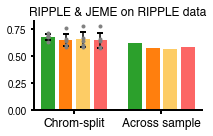

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
chrom_split_data = {
    'RIPPLE':[0.7131338418,0.6827804019,0.6864386573,0.6790811259,0.6322779831],
    'JEME':[0.7555363691,0.6389067404,0.5829851696,0.6033317577,0.6618036644],
    'JEME w/o distance': [0.7821804004,0.6401736646,0.5820713008,0.6045622793,0.6684480477],
    'JEME w/o global': [0.7747067829,0.6349186331,0.5777458463,0.5818318666,0.6623408933]
}
across_sample_data = {
    'RIPPLE':[0.617],
    'JEME':[0.573],
    'JEME w/o distance': [0.568],
    'JEME w/o global': [0.581]
}
keys = ['RIPPLE', 'JEME', 'JEME w/o distance', 'JEME w/o global']
colors = ["#2CA02C", '#FF7F0E', '#FDCC65', '#FC6665']
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.bar(range(4), [np.mean(chrom_split_data[k]) for k in keys], yerr=[np.std(chrom_split_data[k]) for k in keys],
       capsize=3, color=colors, error_kw={'capthick':2}, width=0.77)
ax.bar(range(5,9), [np.mean(across_sample_data[k]) for k in keys],
       capsize=3, color=colors)
for i in range(4):
    ax.plot([i]*5, chrom_split_data[keys[i]], 'o',color='gray', markersize=3 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_xticks([1.5,6.5])
ax.set_xticklabels(['Chrom-split','Across sample'],fontsize=12)
ax.tick_params(width=2)
ax.set_title('RIPPLE & JEME on RIPPLE data')
fig.tight_layout()
fig.savefig('ripple_jeme_on_ripple.pdf')
fig.savefig('ripple_jeme_on_ripple.png', dpi=300)